In [118]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import numpy as np

from datetime import datetime, date, timedelta
import matplotlib as mpl
import dateutil
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
import seaborn as sns
import locale
from pandas import ExcelWriter
import sklearn
from sklearn.linear_model import LinearRegression

In [119]:
sns.set(style='ticks')
# pal = sns.color_palette([
#     [31 / 255, 73 / 255, 125 / 255], #JPMBlue
#     [247 / 255, 150 / 255, 70 / 255], #JPMOrange
#     [155 / 255, 187 / 255, 89 / 255] #JPMGreen
# ])

pal = sns.color_palette([
    [222 / 255, 110 / 255, 116 / 255], #JPMBlue
    [101 / 255, 134 / 255, 194 / 255], #JPMOrange
    [43 / 255, 175 / 255, 100 / 255] #JPMGreen
])

linestyles = [
    {'c': pal[0], 'linestyle': '-'}, 
    {'c': pal[1], 'linestyle': '-'}, 
    {'c': pal[0], 'linestyle': 'dashed'}, 
    {'c': pal[1], 'linestyle': 'dashed'}, 
    {'c': pal[0], 'linestyle': ':'}, 
    {'c': pal[1], 'linestyle': ':'}, 
    {'c': pal[2], 'linestyle': '-'}, 
    {'c': pal[2], 'linestyle': 'dashed'}, 
    {'c': pal[2], 'linestyle': ':'}, 
    
]

barstyles = [
    {'color': pal[0], },
    {'color': pal[0], },
    {'edgecolor': pal[0], 'color': 'white', 'linewidth': 1, 'hatch': '////'},
    {'edgecolor': pal[1], 'color': 'white', 'linewidth': 1, 'hatch': '////'},
    {'edgecolor': pal[0], 'color': 'white', 'linewidth': 1, 'hatch': '....'},
    {'edgecolor': pal[1], 'color': 'white', 'linewidth': 1, 'hatch': '....'},
    
]

rcParams = {
    'font.family' : 'sans-serif',
    'font.sans-serif' : 'Arial',
    'font.weight' : 'bold',
    'font.stretch' : 'condensed',
    'figure.autolayout' : False,
    'hatch.linewidth' : 0.2
}

csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}
# Plantagenet Cherokee

# CHARTDIR
SAVEFIG_KWARGS = {'dpi': 72*4}
LEGEND_KWARGS = {'frameon': True, 'framealpha': 0.9, 'labelspacing': 0.4}
CHART_GAP = timedelta(days=20)
CHART_TITLE_ALIGN = 'left'

# yearsFmt = mdates.DateFormatter('%b-%Y')
# yearsFmt = mdates.DateFormatter('%b-%d')
# yearsFmt = mdates.DateFormatter('%Y')
fontsize = 15
fontweight = 'regular'
title_fontsize = 15
title_fontweight = 'regular'
tick_label_size = 15
tick_label_weight = 'regular'
legend_title_fontsize = 15
legend_title_fontweight = 'regular'
legend_label_fontsize = 15
legend_label_fontweight = 'regular'

annotation_fontsize = 15
annotation_fontweight = 'regular'
xticks_params = {
    'pad' : 1,
    'length' : 3,
}
yticks_params = {
    'pad' : 2,
    'length' : 2,
}

savefig_params = {
    'bbox_inches' : 'tight',
    'pad_inches' : 0.4,
}
xlabel_params = {
    'position' : (0.5,0.5),
    'fontsize' : 15,
    'fontweight' : 'regular',
    'labelpad': None,
}
ylabel_params = {
    'fontsize' : 15,
    'fontweight' : 'regular',
}


footnote_fontsize = 15
footnote_fontweight = 'regular'
fontname = "Baskerville"
def apply_to_axes(axes, footnote_text = 'AllStuffData'):
    _axes = (axes,) if not isinstance(axes, tuple) else axes
    for ax in axes:
        ax.xaxis.label.set_fontsize(xlabel_params['fontsize'])
        ax.yaxis.label.set_fontsize(ylabel_params['fontsize'])
        for item in [ax.xaxis.label, ax.yaxis.label]:
            item.set_fontweight(fontweight)
            item.set_fontname(fontname)
        
        ax.title.set_fontsize(title_fontsize)
        ax.title.set_fontweight(title_fontweight)
        ax.title.set_fontname(fontname)
        
        for item in ax.get_xticklabels() + ax.get_yticklabels():
            item.set_fontsize(tick_label_size)
            item.set_fontweight(tick_label_weight)
            item.set_fontname(fontname)
            
        if ax.get_legend() is not None:
            lt = ax.get_legend().get_title()
            lt.set_fontsize(legend_title_fontsize)
            lt.set_fontweight(legend_title_fontweight)
            lt.set_fontname(fontname)
            t0 = ax.get_legend().get_texts()[0]
            t0.set_fontsize(legend_label_fontsize)
            t0.set_fontweight(legend_label_fontweight)
            t0.set_fontname(fontname)
        
        footnote = ax.annotate(footnote_text, **footnote_params)
        footnote.set_fontsize(footnote_fontsize)
        footnote.set_fontname(fontname)
        footnote.set_fontweight(footnote_fontweight)
        
    return axes

In [76]:
def _initialize_driver():
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--ignore-ssl-errors')

    prefs = {
        "profile.default_content_settings.popups": 0,
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
        "safebrowsing.enabled": True,
        'extensions.disabled': True,
    }
    options.add_experimental_option("prefs", prefs)
    driver_loc = os.path.join(os.getcwd(),"chromedriver")
    while True:
        try:
            driver = webdriver.Chrome(driver_loc, chrome_options=options)
            break
        except:
            pass
    return driver

In [83]:
driver = _initialize_driver()

/Users/gopal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: use options instead of chrome_options


In [84]:
def find_india_win(link):
    url = "http://www.howstat.com/cricket/statistics"+link[2:]
    xpath = "/html/body/form/table/tbody/tr[2]/td[3]/table[2]/tbody/tr/td[1]/table[1]/tbody/tr[5]/td[2]"
    driver.get(url)
    elem = WebDriverWait(driver, 5).until(
        EC.presence_of_element_located((By.XPATH, xpath)))
    return elem.text

In [85]:
url = "http://www.howstat.com/cricket/statistics/players/PlayerProgressBat_ODI.asp?PlayerID=3600"
res = requests.get(url)
soup = BeautifulSoup(res.content,"lxml")
table = soup.find("table", {"class": "TableLined"})
rows =  table.find_all("tr")

In [86]:
total_list=[]
for item in rows:
    row_list = []
    for thing in item.find_all("td"):
        row_list.append(thing.text.replace('\n','').replace('\r','').replace('\t',''))
        try:
            row_list.append(find_india_win(thing.find('a', href=True)['href']))
        except:
            pass
    total_list.append(row_list)

In [153]:
df = pd.DataFrame(total_list)
df = df[3:-1]
df.columns = [
    'SNo','Date', 'Result','Versus','Ground','D/N','How Dismissed','Runs','B/F','S/R','Blank','Aggr','Avg','Cumulative S/R'
]

In [154]:
df.to_pickle("Kohli_ODI.pkl")

In [155]:
df.head()

,SNo,Date,Result,Versus,Ground,D/N,How Dismissed,Runs,B/F,S/R,Blank,Aggr,Avg,Cumulative S/R
3,1,18/08/2008,Sri Lanka won by 8 wickets,Sri Lanka ...,Rangiri Dambulla Internati...,No,lbw b K M D N Kulasekara ...,12,22,54.55,,12,12.00,54.55
4,2,20/08/2008,India won by 3 wickets,Sri Lanka ...,Rangiri Dambulla Internati...,No,c C K Kapugedera b T Thush...,37,67,55.22,,49,24.50,55.06
5,3,24/08/2008,India won by 33 runs,Sri Lanka ...,R Premadasa Stadium ...,Yes,run out,25,38,65.79,,74,24.67,58.27
6,4,27/08/2008,India won by 46 runs,Sri Lanka ...,R Premadasa Stadium ...,Yes,b T Thushara ...,54,66,81.82,,128,32.00,66.32
7,5,29/08/2008,Sri Lanka won by 112 runs [Duckworth-Lewis],Sri Lanka ...,R Premadasa Stadium ...,Yes,lbw b K M D N Kulasekara ...,31,46,67.39,,159,31.80,66.53


In [169]:
df1 = df[['Runs','S/R','Result']]

In [170]:
df1.head()

,Runs,S/R,Result
3,12,54.55,Sri Lanka won by 8 wickets
4,37,55.22,India won by 3 wickets
5,25,65.79,India won by 33 runs
6,54,81.82,India won by 46 runs
7,31,67.39,Sri Lanka won by 112 runs [Duckworth-Lewis]


In [171]:
for i,row in df1.iterrows():
    res = ""
    if row['Result'].find('won') > -1:
        res = (row['Result'][:row['Result'].find('won')].strip())
    else:
        if "tied" in row['Result']:
            res = "Tied"
        else:
            res = "NA"
    df1.loc[i,'Result_win'] = res
    if res == "India":
        df1.loc[i,'Result_num'] = 1
    elif res == "Tied":
        df1.loc[i,'Result_num'] = 0
    elif res == "NA":
        df1.loc[i,'Result_num'] = np.nan
    else:
        df1.loc[i,'Result_num'] = -1
# df1 = df1[['Runs','Result_num']]
# df1 = df1.dropna()

In [172]:
df1['Runs'] = df1['Runs'].str.replace("*","").str.strip()
df1['Runs'] = df1['Runs'].replace('-', np.nan)
df1['Runs'] = df1['Runs'].astype(float)
df1['S/R'] = df1['S/R'].str.replace("*","").str.strip()
df1['S/R'] = df1['S/R'].replace('-', np.nan)
df1['S/R'] = df1['S/R'].astype(float)

/Users/gopal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/gopal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/gopal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [264]:
pal = sns.color_palette([
    [0 / 255, 255 / 255, 255 / 255], #Blue
    [255 / 255, 255 / 255, 102 / 255], #Yellow
    [255 / 255, 80 / 255, 80 / 255], #Red
    [255 / 255, 153 / 255, 102 / 255] #Orange
])

df1 = df1.dropna()
for i,row in df1.iterrows():
    if row['Result_num'] == float(1):
        df1.at[i,'color'] = pal[0]
        df1.at[i,'class'] = "India won"
    elif row['Result_num'] == float(0):
        df1.at[i,'color'] = pal[1]
        df1.at[i,'class'] = "Match tied or abandoned"
    elif row['Result_num'] == float(-1):
        df1.at[i,'color'] = pal[2]
        df1.at[i,'class'] = "India lost"
    else:
        df1.at[i,'color'] = pal[1]
        df1.at[i,'class'] = "Match tied or abandoned"

In [292]:
colors = df1.color.tolist()
colors_name = [pal[0],pal[1],pal[2]]
classes_name = ["India won", "Match tied or abandoned", "India lost"]

In [302]:

footnote_params = {
    'xy': (0,-0.15),
    'xycoords':'axes fraction',
    'xytext': (0,-24),
    'textcoords': 'offset points',
    'va': 'top',
    
}
legend_placement_kwargs = {
    'loc': 'upper center',
    'bbox_to_anchor': (.5,-0.11),
    'ncol': 3,
}

grid_kwargs = {
    'linestyle': '-',
    'linewidth': 0.5,
#     'color': 3,
}


SAVEFIG_KWARGS = {'dpi': 72*4}

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['lines.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = COLOR

In [303]:
import matplotlib.patches as mpatches
recs = []
for i in range(0,len(classes_name)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=colors_name[i]))

In [304]:
y_column = 'S/R'
x_column = 'Runs'

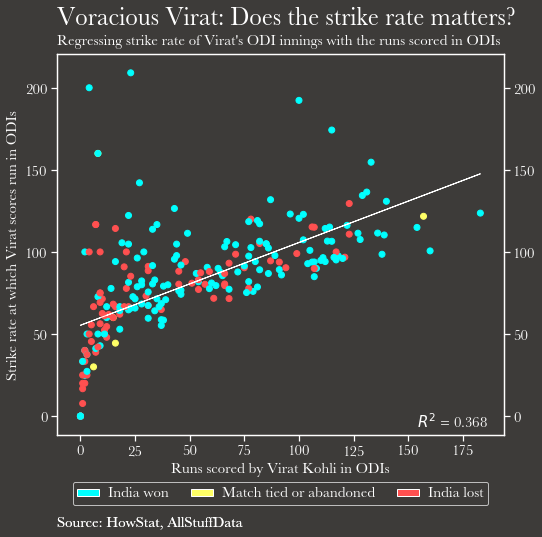

In [309]:
fig, ax = plt.subplots(figsize=(8,7))
df_reg = df1[[y_column, x_column]].dropna()
y = df_reg[[y_column]]
x = df_reg[[x_column]]
reg = LinearRegression()
reg.fit(df_reg[x_column].values.reshape(-1,1),
       df_reg[y_column].values.reshape(-1,1))

Yhat = reg.predict(df_reg[x_column].values.reshape(-1,1))
r2 = round(reg.score(df_reg[x_column].values.reshape(-1,1),
                    df_reg[y_column].values.reshape(-1,1)),4)

beta = reg.coef_[0][0]
alpha = reg.intercept_[0]

k = 0
for i,row in df_reg.iterrows():
    df_reg.loc[i,'pred_'+y_column] = Yhat.tolist()[k][0]
    k=k+1
ax.plot(x,df_reg[['pred_'+y_column]],linewidth=1, c = COLOR)
points = ax.scatter(x,y, c =colors)
ax.set_xlabel("Runs scored by Virat Kohli in ODIs")
ax.set_ylabel("Strike rate at which Virat scores run in ODIs")
mpl.rcParams['savefig.facecolor'] = (61.0/255, 58.5/255, 57.0/255)
ax.set_facecolor((61.0/255, 58.5/255, 57.0/255))
fig.patch.set_facecolor((61.0/255, 58.5/255, 57.0/255))
fig.text(0.75,0.14,"$R^2$ = "+str(r2),fontdict={'fontsize':15,'fontweight':'bold', 'fontname':'Baskerville'})
ax1 = ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax.set_title('Voracious Virat: Does the strike rate matters?', loc=CHART_TITLE_ALIGN, fontdict={'fontsize':25,'fontweight':'bold', 'fontname':'Baskerville'}, pad=30 )
ax.legend(recs, classes_name, **LEGEND_KWARGS,**legend_placement_kwargs,facecolor =(61.0/255, 58.5/255, 57.0/255))
fig.text(0.125,0.9,"Regressing strike rate of Virat's ODI innings with the runs scored in ODIs",fontdict={'fontsize':15,'fontweight':'regular','fontname':'Baskerville'})
footnote_text = "Source: HowStat, AllStuffData"
apply_to_axes((ax,ax1),footnote_text = footnote_text)
f = os.path.dirname(os.getcwd())+'/todays_chart/kohli_1.jpg'
fig.savefig(f, **SAVEFIG_KWARGS, **savefig_params, transparent = True)